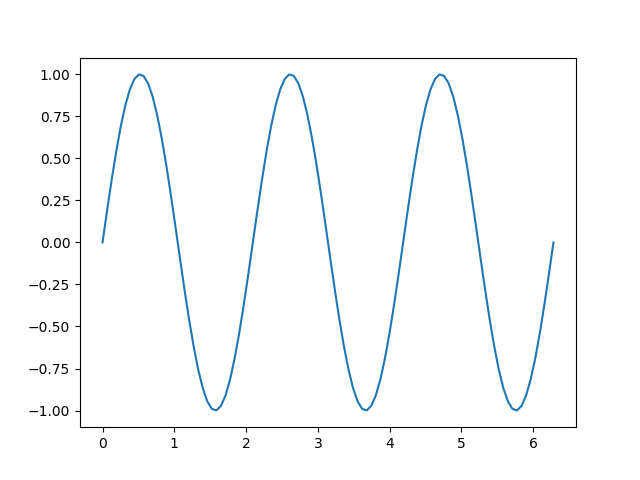

In [1]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)

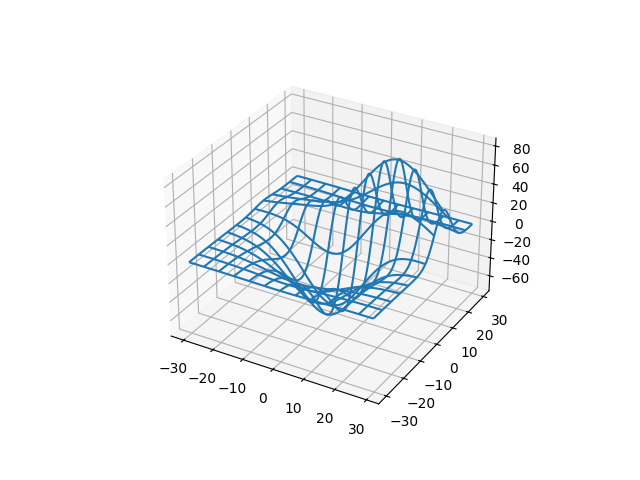

In [2]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()
